# South Africa COVID-19 projections

Inspired by "[Covid-19 infection in Italy. Mathematical models and predictions](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d)"
by Gianluca Malato.

This is a quick experiment to fit South Africa's COVID-19 case numbers to the
[logistic function](https://en.wikipedia.org/wiki/Logistic_function), to make some projections.

First, get the raw data, and extract the bits we're interested in:

In [1]:
import pandas as pd


# Latest data:
# url = 'https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/South_Africa_medical_cases'
# Last known good data (2020-03-27):
url = 'https://en.wikipedia.org/w/index.php?title=Template:2019%E2%80%9320_coronavirus_pandemic_data/South_Africa_medical_cases&oldid=947656558'

table_title = 'COVID-19 cases in South Africa by province'

full_df: pd.DataFrame
[full_df] = pd.read_html(url, match=table_title)

In [2]:
# print(full_df.columns)

df: pd.DataFrame
df = full_df[[('2020', '2020'), ('Confirmed', 'Total')]]

# Drop the last four (non-data) rows.
df = df[:-3]
# Manual clean-up…
df[('Confirmed', 'Total')][11] = df[('Confirmed', 'Total')][11].replace('[b]', '')
# Make sure it's all coerced to numeric.
df[('Confirmed', 'Total')] = pd.to_numeric(df[('Confirmed', 'Total')])

df

,2020,Confirmed
,2020,Total
0,03-04,0
1,03-05,1
2,03-06,1
3,03-07,2
4,03-08,3
5,03-09,7
6,03-10,10
7,03-11,13
8,03-12,16


Define the logistic function, with some scaling parameters:

In [3]:
from scipy.special import expit


def logistic(t, rate, mid, limit):
    """
    :param t: Time (days) 
    :param rate: Growth rate constant
    :param mid: Inflection point
    :param limit: Population limit
    """
    return limit * expit(rate * (t - mid))

Curve-fit the data:

In [4]:
import numpy as np
from scipy.optimize import curve_fit


# Helper function
def estimates(xdata, ydata):
    """
    Return a set of fitted parameters.
    """
    initial_guesses = [0.25, 60, 10_000_000]
    
    # def best_fit():
    #     popt, pcov = curve_fit(
    #         logistic,
    #         xdata=xdata,
    #         ydata=ydata,
    #         p0=initial_guesses,
    #     )
    #     errors = np.sqrt(pcov.diagonal())
    #     return popt, errors

    # Like best_fit, but fix the rate.
    # def rate_fit(rate):
    #     popt, pcov = curve_fit(
    #         lambda t, mid, limit: logistic(t, rate, mid, limit),
    #         xdata=xdata,
    #         ydata=ydata,
    #         p0=initial_guesses[1:],
    #     )
    #     return [rate] + list(popt)
    
    # Like best_fit, but fix the limit.
    def limit_fit(limit):
        popt, pcov = curve_fit(
            lambda t, rate, mid: logistic(t, rate, mid, limit),
            xdata=xdata,
            ydata=ydata,
            p0=initial_guesses[:2],
            # maxfev=10000,
        )
        return list(popt) + [limit]

    # Best-fit parameters
    # p_mid, errors = best_fit()
    
    # Low and high parameters, using the rate's variance
    # rate = p_mid[0]
    # rate_error = errors[0]
    # p_min = rate_fit(rate + rate_error)
    # p_max = rate_fit(rate - rate_error)
    
    # Parameters based on the projected infection percentages of SA's population.
    sa_population = 58_780_000  # https://en.wikipedia.org/wiki/Demographics_of_South_Africa
    p_10pct = limit_fit(sa_population * 0.10)
    p_20pct = limit_fit(sa_population * 0.20)
    p_40pct = limit_fit(sa_population * 0.40)
    
    # return p_min, p_mid, p_max, p_10pct, p_20pct, p_40pct
    return p_10pct, p_20pct, p_40pct


# XXX: For now, just assume the data has no gaps, and days equal indexes.
data_days = range(len(df))
data_cases = df[('Confirmed', 'Total')]

p_10pct, p_20pct, p_40pct = estimates(data_days, data_cases)

# Show the parameters with Python's float formatting
pd.options.display.float_format = str

pd.DataFrame(
    data=[p_10pct, p_20pct, p_40pct],
    index=['10%', '20%', '40%'],
    columns=['Rate', 'Midpoint', 'Limit'],
)    

,Rate,Midpoint,Limit
10%,0.2646143581322761,55.15391275483938,5878000.0
20%,0.2646010319672306,57.77548449471133,11756000.0
40%,0.26459436661410324,60.39619951829452,23512000.0


Plot some data!

This is also plotted [here](https://docs.google.com/spreadsheets/d/1zJC06iokpJ65-ZdJCgqCAIgpYpUTwOlpcxI_27wTtn8/edit#gid=384217832).

In [5]:
import matplotlib.pyplot as plt


# plt.plot(logistic(range(int(np.ceil(p_min[1] * 2))), *p_min), 'g:', label='Low')
# plt.plot(logistic(range(int(np.ceil(p_mid[1] * 2))), *p_mid), 'b--', label='Best-fit')
# plt.plot(logistic(range(int(np.ceil(p_max[1] * 2))), *p_max), 'r:', label='High')
# 
# plt.plot(data_cases, 'k.-', label='Confirmed')
# 
# plt.title('Projection based on confirmed cases')
# plt.xlabel('Days')
# plt.ylabel('Cases')
# plt.legend()
# plt.show()

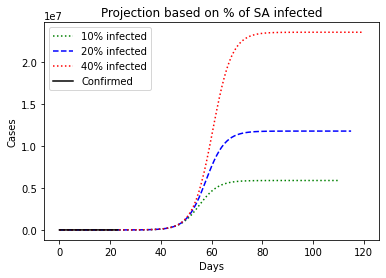

In [6]:
plt.plot(logistic(range(int(np.ceil(p_10pct[1] * 2))), *p_10pct), 'g:', label='10% infected')
plt.plot(logistic(range(int(np.ceil(p_20pct[1] * 2))), *p_20pct), 'b--', label='20% infected')
plt.plot(logistic(range(int(np.ceil(p_40pct[1] * 2))), *p_40pct), 'r:', label='40% infected')
plt.plot(data_days, data_cases, 'k-', label='Confirmed')

plt.title('Projection based on % of SA infected')
plt.xlabel('Days')
plt.ylabel('Cases')
plt.legend()
plt.show()